#**WEEK 10 TEMPORAL DIFFERENCE-SARSA, Q-LEARNING**

In [ ]:
# Importing Libraries
import gym
import os
import matplotlib
import numpy as np
import random
import itertools
import pandas as pd
import sys
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
env = gym.make('Taxi-v3')

In [ ]:
print ("Number of states:", env.observation_space.n)
print ("Number of actions that an agent can take:", env.action_space.n)

Number of states: 500
Number of actions that an agent can take: 6


In [ ]:
actions = ["south", "north", "east", "west", "pickup", "dropoff"]

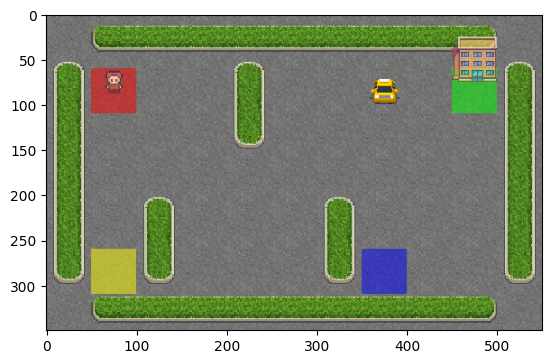

In [ ]:
env.reset()
plt.imshow( env.render(mode='rgb_array') )
plt.show()

Function to make Greedy Policy

In [ ]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    return policy_fn

Funciton to Plot Rewards Smoothened over Window size 10

In [ ]:
def plot_episode_rewards(e_rewards, smoothing_window=10):
  smoothed_rewards = pd.Series(e_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
  plt.plot(smoothed_rewards)
  plt.title("Episode Rewards Smoothened over a window size of 10")
  plt.xlabel("Epiosdes")
  plt.ylabel("Rewards")

Function to Play an episode

In [ ]:
def play_episode(env, policy,verbose=False, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    state = env.reset()
    action = policy[state]
    # action = np.random.choice(np.arange(len(probs)), p=probs)
    
    while True:
        if verbose:
          clear_output(wait=True)
          plt.imshow( env.render(mode='rgb_array') )
          plt.show()
          time.sleep(1)
        # Take a step
        next_state, reward, is_terminal, _ = env.step(action)
        
        # Pick the next action
        next_action = policy[next_state]
        
        if is_terminal:
            break
        
        state = next_state
        action = next_action

Function to play recorded video

In [ ]:
import io
import base64
from IPython.display import HTML

def ipython_show_video(path):
    """Show a video at `path` within IPython Notebook
    """
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))
    ))

## 1. **SARSA**

In [ ]:
# generate a episode in Taxi environment for above sample_policy
def generate_episode(policy, verbose=False):
    episode = []
    env = gym.make('Taxi-v3')
    curr_state = env.reset()
    probs = policy(curr_state)
    print(probs)
    action = np.random.choice(np.arange(len(probs)), p=probs)
    
    while True:
        if verbose:
            print ("Current observation:")
            print ("Current poistion:", curr_state)
            #print (env.render())
        
        next_state, reward, is_terminal, _ = env.step(action)
        
        if verbose:
            print ("Action taken:", actions[action])
            print ("Next observation:", next_state)
            print ("Reward recieved:", reward)
            print ("Terminal state:", is_terminal)
            #print (env.render())
            print ("-"*20)
        episode.append((curr_state, action, reward))
        
        # Pick the next action
        next_probs = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
    
        curr_state = next_state
        action = next_action

        if (is_terminal):
            break

    return episode

In [ ]:
%%time 
Q = defaultdict(lambda: np.zeros(env.action_space.n))
policy = make_epsilon_greedy_policy(Q, 0.1, env.action_space.n)
e = generate_episode(policy,verbose=False)
#print ("Episode:", e)
print ("Length of episode:", len(e))

[0.91666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667]
Length of episode: 200
CPU times: user 43.2 ms, sys: 1.86 ms, total: 45.1 ms
Wall time: 83 ms


In [ ]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    episode_rewards = np.zeros(num_episodes)

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            episode_rewards[i_episode] += reward

            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            if is_terminal:
                break
            
            state = next_state
            action = next_action

    return Q, episode_rewards

In [ ]:
env = gym.make('Taxi-v3')
Q, sarsa_rew = sarsa(env, 2000)
env.close()

Episode 2000/2000.

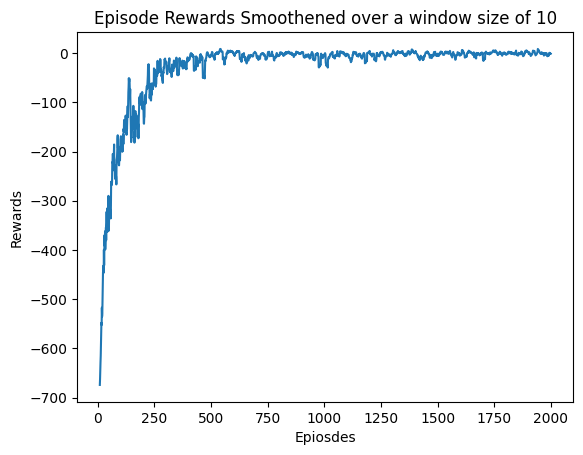

In [ ]:
plot_episode_rewards(sarsa_rew)

In [ ]:
final_policy = defaultdict(lambda: np.zeros(env.obervation_space.n))
for s in range(env.observation_space.n):
  best_action = np.argmax(Q[s])
  final_policy[s] = best_action

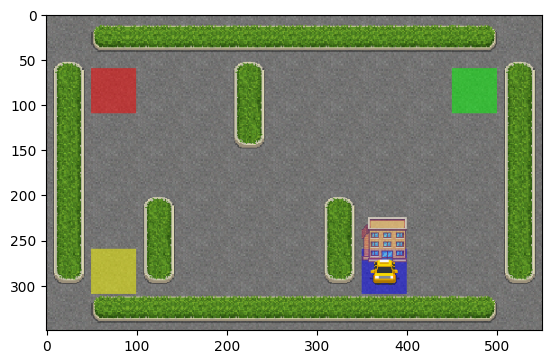

In [ ]:
import time
from gym import wrappers
env = gym.make('Taxi-v3')
env = wrappers.RecordVideo(env, "./gym-results/sarsa")
play_episode(env,final_policy,verbose=True)
env.close()

In [ ]:
ipython_show_video('/content/gym-results/sarsa/rl-video-episode-0.mp4')

## 2. **Q-Learning**

In [ ]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    episode_rewards = np.zeros(num_episodes)

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            best_action = np.argmax(Q[next_state])
            
            td_target = reward + discount_factor * Q[next_state][best_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            episode_rewards[i_episode] += reward

            if is_terminal:
                break
            
            state = next_state
            action = best_action

    return Q, episode_rewards

In [ ]:
env = gym.make('Taxi-v3')
Q2, qlearn_rew = q_learning(env,2000)
env.close()

Episode 2000/2000.

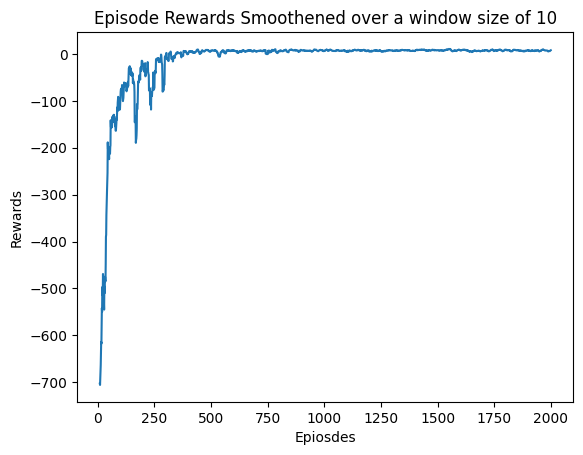

In [ ]:
plot_episode_rewards(qlearn_rew)

In [ ]:
final_policy2 = defaultdict(lambda: np.zeros(env.obervation_space.n))
for s in range(env.observation_space.n):
  best_action = np.argmax(Q2[s])
  final_policy2[s] = best_action

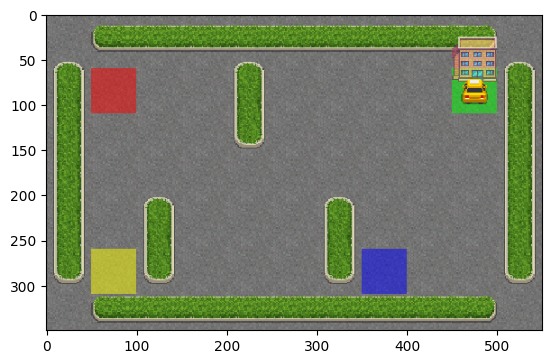

In [ ]:
import time
from gym import wrappers
env = gym.make('Taxi-v3')
env = wrappers.RecordVideo(env, "./gym-results/q-learning")
play_episode(env,final_policy2,verbose=True)
env.close()

In [ ]:
ipython_show_video('/content/gym-results/q-learning/rl-video-episode-0.mp4')

## **Expected SARSA**

In [ ]:
def expected_sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    episode_rewards = np.zeros(num_episodes)

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            episode_rewards[i_episode] += reward

            expected_q = np.sum(next_probs[a]* Q[next_state][a] for a in range(env.action_space.n))
            td_target = reward + discount_factor * expected_q
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            if is_terminal:
                break
            
            state = next_state
            action = next_action

    return Q, episode_rewards

In [ ]:
env = gym.make('Taxi-v3')
Q3, expected_sarsa_rew = expected_sarsa(env,2000)
env.close()

Episode 2000/2000.

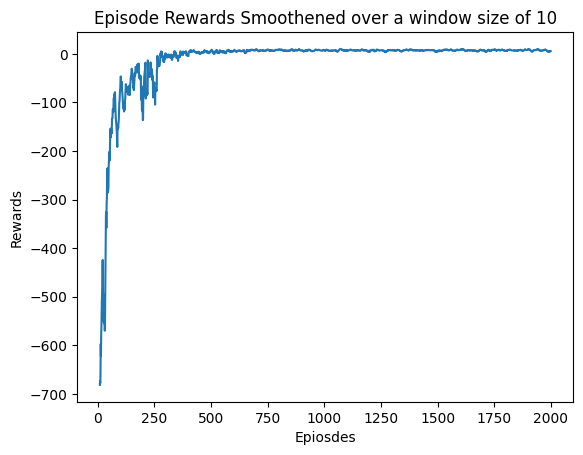

In [ ]:
plot_episode_rewards(expected_sarsa_rew)

In [ ]:
final_policy3 = defaultdict(lambda: np.zeros(env.obervation_space.n))
for s in range(env.observation_space.n):
  best_action = np.argmax(Q3[s])
  final_policy3[s] = best_action

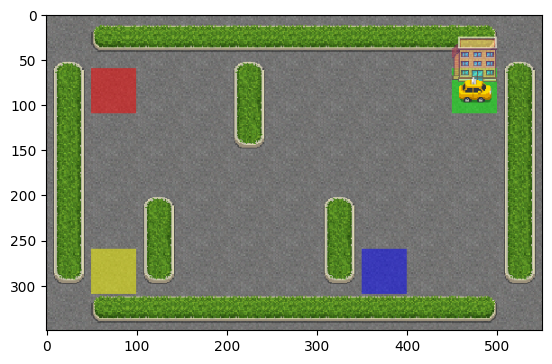

In [ ]:
env = gym.make('Taxi-v3')
env = wrappers.RecordVideo(env, "./gym-results/expected-sarsa")
play_episode(env,final_policy3,verbose=True)
env.close()

In [ ]:
ipython_show_video('/content/gym-results/expected-sarsa/rl-video-episode-0.mp4')